# Space time worm

In [146]:
import os
from pathlib import Path
import json
import requests

#import netCDF4 as nc
import xarray as xr
import numpy as np
import pandas as pd
from geojson import Feature, Point, FeatureCollection, MultiPolygon, Polygon, load as geojson_load
from matplotlib import pyplot as plt
import folium

---

## 1 ) Helper functions

In [2]:
# earth radius in km
r = 6371 

# distance between two meridians (1 deg longitude) in km at given latitude
def dist_meridian_km(lat):
    u = 2*np.pi*r
    return np.cos(np.deg2rad(lat)) * u / 360

def dist_lon_deg(d_km, lat):
    return d_km / dist_meridian_km(lat)

def dist_lat_deg(d_km):
    return d_km * 360 / (2*np.pi*r)

def corridor_bbox(p, lat):
    return [p[0]-dist_lon_deg(dist, lat), 
         p[1]-dist_lat_deg(dist),
         p[0]+dist_lon_deg(dist, lat),
         p[1]+dist_lat_deg(dist)]

def bbox_to_polygon(bbox):
    return [[[bbox[0],bbox[1]],[bbox[2],bbox[1]],[bbox[2],bbox[3]],[bbox[0],bbox[3]],[bbox[0],bbox[1]]]]

def walk_groups(top):
    yield top.groups.values()
    for value in top.groups.values():
        yield from walktree(value)

In [3]:
#date_to_str = lambda x: x.strftime('%Y-%m-%dT%H:%M:%SZ')
date_to_str = lambda x: x.strftime('%Y-%m-%dT%H:%M')

GFS_VAR_LIST = ['u-component_of_wind_maximum_wind', 'v-component_of_wind_maximum_wind', 'Temperature_surface']
WAVE_VAR_LIST = ['VHM0','VPED','VTPK']
PHYS_VAR_LIST =['so','uo','vo']

def build_env_data_url(lon_lo, lon_hi, lat_lo, lat_hi, date_lo, date_hi, 
                       wave_params=WAVE_VAR_LIST, phys_params=PHYS_VAR_LIST,
                       gfs_params=GFS_VAR_LIST, format='netcdf'):
    base_url = 'https://harvester.maridata.dev.52north.org/EnvDataAPI/request_env_data?'
    url = base_url + 'date_lo={}'.format(date_to_str(date_lo))
    url = url + '&date_hi={}'.format(date_to_str(date_hi))
    url = url + '&lat_lo={}'.format(lat_lo)
    url = url + '&lat_hi={}'.format(lat_hi)
    url = url + '&lon_lo={}'.format(lon_lo)
    url = url + '&lon_hi={}'.format(lon_hi)
    for param in wave_params:
        url = url + '&Wave={}'.format(param)
    for param in phys_params:
        url = url + '&Physical={}'.format(param)
    for param in gfs_params:
        url = url + '&GFS={}'.format(param)
    url = url + '&format={}'.format(format)

    return url

In [159]:
def transform_coordinates(dataset, point):
    dataset = dataset.assign_coords(longitude=lambda dataset: dataset.longitude - point[0])
    dataset = dataset.assign_coords(latitude=lambda dataset: dataset.latitude - point[1])
    #print(dataset)
    return dataset

In [160]:
def save_with_groups(datasets, out, group_base='point'):
    """
    Save xarray datasets to netCDF file adding every dataset as separate group
    :param datasets: list of xarray datasets
    :out: str
        name of output file (absolute path)
    :group_base: str
        base name of the group (number is appended automatically)
    :returns: filename of created file
    """
    if Path(out).exists():
        try:
            os.remove(out)
            print('Removed file {}'.format(out))
        except OSError:
            pass
    
    for idx, dataset in enumerate(datasets):
        if idx == 0:
            dataset.to_netcdf(out, 'w', group='/{}_{}'.format(group_base, idx+1))
        else:
            dataset.to_netcdf(out, 'a', group='/{}_{}'.format(group_base, idx+1))
    
    return out

def save_with_local_grid(datasets, out):
    pass

---

## netCDF compression

In [5]:
# Define sample data with all elements masked out
#N = 1000
#data = np.ma.masked_all((N, N))

In [6]:
# Write data to netCDF file using different data formats
#for fmt in ('NETCDF3_CLASSIC', 'NETCDF4'):
#    fname = 'test.nc'
#    ds = netCDF4.Dataset(fname, format=fmt, mode='w')
#    xdim = ds.createDimension(dimname='x', size=N)
#    ydim = ds.createDimension(dimname='y', size=N)
#    var = ds.createVariable(
#        varname='data',
#        dimensions=(ydim.name, xdim.name),
#        fill_value=-999,
#        datatype='f4',
#        complevel=9,  # set gzip compression level
#        zlib=True  # enable compression
#    )
#    var[:] = data
#    ds.close()
#
#    # Determine file size
#    print(fmt, os.stat(fname).st_size)

---

## 2) Define route 

### 2.1) From scrubber data 

<ol>
  <li>Read example scrubber trajectory data</li>
  <li>Define time series for 2 days with a 3-hour interval</li>
  <li>Extract coordinates for time series from step 2</li>
  <li>Create geojson with time series and coordinates</li>
</ol>


In [7]:
#df = pd.read_csv('/home/martin/Projekte/MariData/data/Buettner/CB_scrubber_parsed.csv')

In [8]:
#times = pd.date_range("2021-04-02 00:00:00", periods=16, freq="3H")
#times

In [9]:
#time_filter = [False] * len(df)
#for time in times:
#    time_filter = time_filter | (df['Date/Time (UTC)'] >= str(time+pd.Timedelta(-2,'m'))) & (df['Date/Time (UTC)'] <= str(time+pd.Timedelta(2,'m')))

#df_filtered = df[time_filter]
#print(len(df_filtered))
#df_filtered

In [10]:
#points = list(zip(round(df_filtered['Longitude'], 1),round(df_filtered['Latitude'], 1)))
#points

In [11]:
#point_features = []

#for idx, point in enumerate(points):
#    point_features.append(Feature(geometry=Point(point), properties={"time": str(times[idx])}))

#route_geojson = FeatureCollection(point_features)
#print(json.dumps(route_geojson, indent=2))

### 2.2) From geojson 

In [12]:
with open('space_time_worm.geojson') as f:
    route_geojson = geojson_load(f)
times = pd.date_range(route_geojson['features'][0]['properties']['time'],route_geojson['features'][-1]['properties']['time'], freq="3H")
points = [tuple(p['geometry']['coordinates']) for p in route_geojson['features'] if p['geometry']['type']=='Point']

---

## 3) Define bboxes

In [13]:
# Distance/width of the corridor (total width/total height of bbox = 2*distance)
dist = 30
# Use maximum latitude as it will produce the largest bbox
lat_max = np.max([p[1] for p in points])
print('Maximum latitude:', lat_max)

Maximum latitude: 51.3


In [14]:
bboxes = []
polygon_features = []
for idx, p in enumerate(points):
    bbox = corridor_bbox(p, lat_max)
    bboxes.append(bbox)
    polygon = bbox_to_polygon(bbox)
    polygon_features.append(Feature(geometry=Polygon(polygon), properties={"time": str(times[idx])}))
    print("[{0:.3f}, {1:.3f}, {2:.3f}, {3:.3f}]".format(*bbox))

bboxes_geojson = FeatureCollection(polygon_features)

[-2.432, 45.530, -1.568, 46.070]
[-3.232, 45.930, -2.368, 46.470]
[-4.032, 46.330, -3.168, 46.870]
[-4.732, 46.830, -3.868, 47.370]
[-5.532, 47.330, -4.668, 47.870]
[-6.132, 47.830, -5.268, 48.370]
[-6.132, 48.430, -5.268, 48.970]
[-5.232, 48.830, -4.368, 49.370]
[-4.432, 49.130, -3.568, 49.670]
[-3.632, 49.430, -2.768, 49.970]
[-2.832, 49.630, -1.968, 50.170]
[-2.032, 49.730, -1.168, 50.270]
[-0.832, 49.930, 0.032, 50.470]
[0.268, 50.130, 1.132, 50.670]
[0.968, 50.630, 1.832, 51.170]
[1.668, 51.030, 2.532, 51.570]


In [15]:
print(json.dumps(bboxes_geojson, indent=2))

{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -2.431507,
              45.530204
            ],
            [
              -1.568493,
              45.530204
            ],
            [
              -1.568493,
              46.069796
            ],
            [
              -2.431507,
              46.069796
            ],
            [
              -2.431507,
              45.530204
            ]
          ]
        ]
      },
      "properties": {
        "time": "2021-04-02 00:00:00"
      }
    },
    {
      "type": "Feature",
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -3.231507,
              45.930204
            ],
            [
              -2.368493,
              45.930204
            ],
            [
              -2.368493,
              46.469796
       

In [16]:
#print(json.dumps(FeatureCollection(point_features+polygon_features), indent=2))

---

## x) Visualize route and bboxes 

In [89]:
route_map = folium.Map( location=[49.0, -1.5], zoom_start=6 )
for idx in range(0, len(route_geojson['features'])):
    folium.GeoJson(data=route_geojson['features'][idx]['geometry']).add_to(route_map) \
    .add_child(folium.Popup(route_geojson['features'][idx]['properties']['time'])).add_to(route_map)
route_map

---

## 4) Get environmental data along route 

### Download data

Download data using the Environmental Data API: https://harvester.maridata.dev.52north.org/EnvDataAPI/

Documentation: https://github.com/52North/MariDataHarvest/tree/main/EnvDataServer

In [111]:
#data_links = []
#headers = {'Accept': 'application/json'}
#
#for j in range(0, len(bboxes)):
#    if len(bboxes) != len(times):
#        break
#    lon_lo = bboxes[j][0]
#    lon_hi = bboxes[j][2]
#    lat_lo = bboxes[j][1]
#    lat_hi = bboxes[j][3]
#    date_lo = times[j]
#    date_hi = times[j]
#    
#    url = build_env_data_url(lon_lo, lon_hi, lat_lo, lat_hi, date_lo, date_hi)
#    print('Requesting: {}'.format(url))
#    resp = requests.get(url, headers=headers)
#    if resp.status_code == 200:
#        resp_data = resp.json()
#        data_links.append(resp_data['link'])
#        print('Response: {}'.format(resp_data))
#    else:
#        print('Response: {}'.format(resp.status_code))

Requesting: https://harvester.maridata.dev.52north.org/EnvDataAPI/request_env_data?date_lo=2021-04-02T12:00&date_hi=2021-04-02T12:00&lat_lo=47.33020351822438&lat_hi=47.86979648177562&lon_lo=-5.531506838251867&lon_hi=-4.668493161748132&Wave=VHM0&Wave=VPED&Wave=VTPK&Physical=so&Physical=uo&Physical=vo&GFS=u-component_of_wind_maximum_wind&GFS=v-component_of_wind_maximum_wind&GFS=Temperature_surface&format=netcdf
Response: {'limit': '2021-12-17T18:18:37+00:00', 'link': 'https://harvester.maridata.dev.52north.org/EnvDataAPI/fd3134fa-5f54-11ec-88c5-0242ac120003.nc'}


In [120]:
#data_links

['https://harvester.maridata.dev.52north.org/EnvDataAPI/fd3134fa-5f54-11ec-88c5-0242ac120003.nc']

### Load from files

In [17]:
base_source = '/home/martin/Projekte/MariData/software/space_time_worm/source_data/17_12_2021'
file_names = []

for file in os.listdir(base_source):
    file_names.append(os.path.join(base_source, file))

In [122]:
datasets = []
for file_name in file_names:
    datasets.append(xr.load_dataset(file_name))

In [123]:
# Sort by time
datasets.sort(key=lambda l: l.time[0])

---

## 5) Visualize environmental data

ToDo: preprocessing (reduce time dimension and sort datasets, ...)

In [124]:
# For debug
#ds_times = []
#for dataset in datasets:
#    ds_times.append(dataset.time.values)
#    print(dataset.time.values)
#ds_times = [item for sublist in ds_times for item in sublist]

In [125]:
# For debug
#ds_times.sort()
#ds_times

In [21]:
# For debug
#times.strftime("%Y-%m-%d %H:%M:%S").tolist().index('2021-04-02 09:00:00')
#times.strftime("%Y-%m-%d %H:%M:%S").tolist().index('2021-04-02 12:00:00')

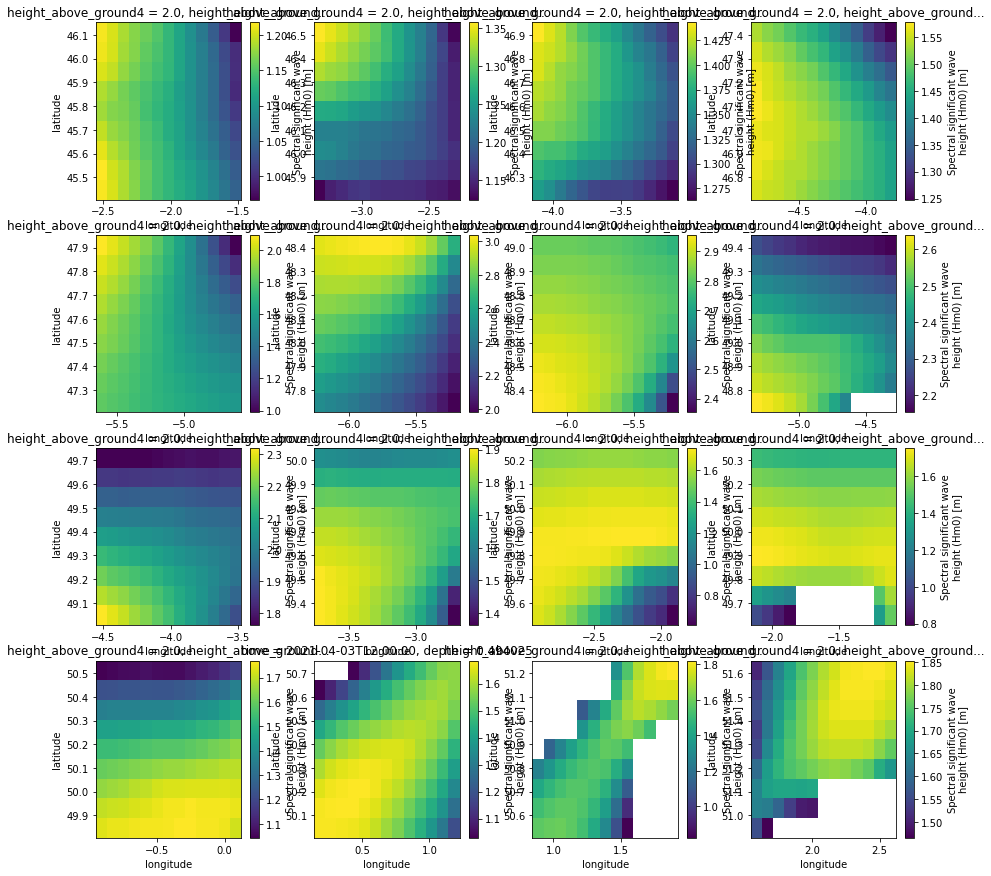

In [126]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(15,15))

col = 0
row = 0
for idx, dataset in enumerate(datasets):
    idx = idx + 1
    #print(idx, row, col)
    dataset.isel(time=0).VHM0.plot(ax=axes[row, col])
    #dataset.isel(time=0).VHM0.plot(ax=axes[row, col], vmin=1.2, vmax=2.7)
    if idx % 4 == 0:
        row = row + 1
        col = 0
    else:
        col = col + 1

---

## 6) Space time worm with netCDF groups

xarray does not support a data structure with multiple groups. A Dataset corrsponds to a single group in a netCDF file.
http://xarray.pydata.org/en/stable/user-guide/io.html#groups

In [127]:
out = '/home/martin/Projekte/MariData/software/space_time_worm/cmems_cube_groups.nc'

### 6.1) Save data

In [129]:
#save_with_groups(datasets, out)

### 6.2) Load data

In [130]:
datasets_group = []
for idx in range(1,17):
    datasets_group.append(xr.load_dataset(out, group='point_{}'.format(idx)))
#datasets_group

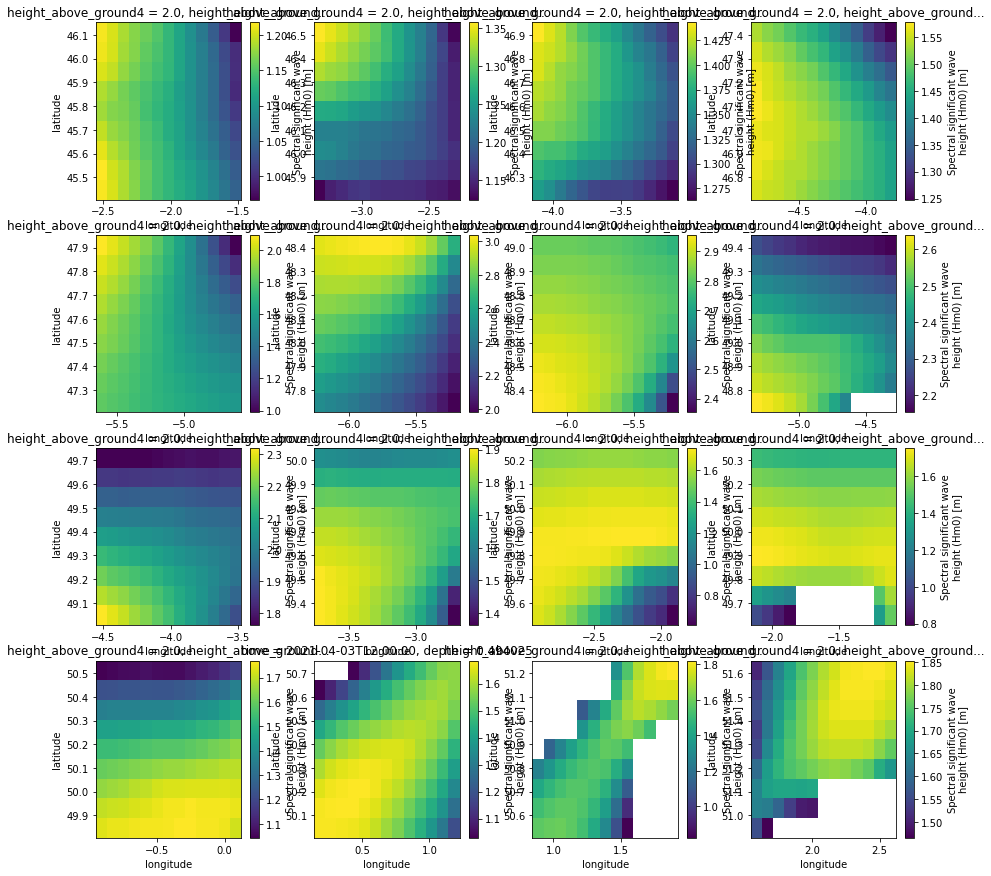

In [131]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(15,15))

col = 0
row = 0
for idx, dataset in enumerate(datasets_group):
    idx = idx + 1
    #print(idx, row, col)
    dataset.isel(time=0).VHM0.plot(ax=axes[row, col])
    #dataset.isel(time=0).VHM0.plot(ax=axes[row, col], vmin=1.2, vmax=2.7)
    if idx % 4 == 0:
        row = row + 1
        col = 0
    else:
        col = col + 1

---

## 7) Space time worm with relative coordinates (single grid)

Challenges:
* How to make sure all relative grids are identical?

### 7.1) Transform grid

In [161]:
datasets_rel_coords = []
# Make sure order of datasets and points is correct
for idx, dataset in enumerate(datasets):
    datasets_rel_coords.append(transform_coordinates(dataset.copy(), points[idx]))
#datasets_rel_coords

In [162]:
for dataset in datasets_rel_coords:
    #print(dataset.longitude.values)
    print(dataset.latitude.values)

[-0.3528 -0.2698 -0.1868 -0.1038 -0.0208  0.0622  0.1452  0.2282  0.3112]
[-0.3528 -0.2698 -0.1868 -0.1038 -0.0208  0.0622  0.1452  0.2282  0.3112]
[-0.3528 -0.2698 -0.1868 -0.1038 -0.0208  0.0622  0.1452  0.2282  0.3112]
[-0.3528 -0.2698 -0.1868 -0.1038 -0.0208  0.0622  0.1452  0.2282  0.3112]
[-0.3528 -0.2698 -0.1868 -0.1038 -0.0208  0.0622  0.1452  0.2282  0.3112]
[-0.3528 -0.2698 -0.1868 -0.1038 -0.0208  0.0622  0.1452  0.2282  0.3112]
[-0.3528 -0.2698 -0.1868 -0.1038 -0.0208  0.0622  0.1452  0.2282  0.3112]
[-0.3528 -0.2698 -0.1868 -0.1038 -0.0208  0.0622  0.1452  0.2282  0.3112]
[-0.3528 -0.2698 -0.1868 -0.1038 -0.0208  0.0622  0.1452  0.2282  0.3112]
[-0.3528 -0.2698 -0.1868 -0.1038 -0.0208  0.0622  0.1452  0.2282  0.3112]
[-0.3528 -0.2698 -0.1868 -0.1038 -0.0208  0.0622  0.1452  0.2282  0.3112]
[-0.3528 -0.2698 -0.1868 -0.1038 -0.0208  0.0622  0.1452  0.2282  0.3112]
[-0.3528 -0.2698 -0.1868 -0.1038 -0.0208  0.0622  0.1452  0.2282  0.3112]
[-0.3528 -0.2698 -0.1868 -0.1038 -0.02

### 7.2) Combine datasets

In [166]:
combined = xr.concat(datasets_rel_coords, dim='time', coords='minimal')
combined

ValueError: 'u-component_of_wind_maximum_wind' is not present in all datasets.

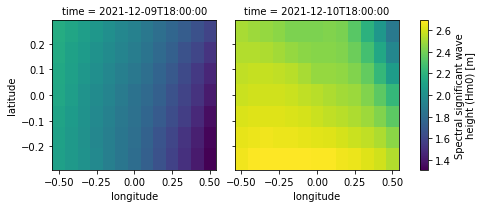

In [30]:
combined.VHM0.plot(x="longitude", y="latitude", col="time");

In [31]:
# ToDo: add grid transform to attributes

In [32]:
out = '/home/martin/Projekte/MariData/software/space_time_worm/cmems_cube_relative_coordinates.nc'
combined.to_netcdf(out)

---

## 8) Memory comparison

In [28]:
#print(os.stat(base + 'global-analysis-forecast-wav-001-027_1639067263072.nc').st_size / 1000, 'kB')
#print(os.stat(base + 'global-analysis-forecast-wav-001-027_1639067209562.nc').st_size / 1000, 'kB')